In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from matplotlib import pyplot as plt 
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed

from utils import * 

In [2]:
def date_to_datetime(data):
    data.time = pd.to_datetime(data.time, infer_datetime_format=True)

    data = data.set_index('time', drop=True)  

    return data    

In [3]:
def slice_dates(data, beginning_date, end_date):
    return data[(data.index>=beginning_date)&(data.index<=end_date)]


In [4]:
data_v1 = pd.read_csv("data/data_v1.csv")
data_v2 = pd.read_csv("data/data_v2.csv")

data_v1 = date_to_datetime(data_v1)
data_v2 = date_to_datetime(data_v2)


In [5]:
data = data_v2.dropna()

In [6]:
from sklearn.model_selection import ParameterGrid
param_grid = {'model': [LinearRegression(), GradientBoostingRegressor()], 
              'num_periods_lagged':[0, 1, 2, 24],
              'num_periods_diffed':[0],
              "lags": [[]],
              'hour': [True],
              'weekday':[True],
              'month':[True],
              'holidays': [True],
              'rolling' : [[],[np.mean,np.min,np.max,np.std]]
             }

grid = ParameterGrid(param_grid)

In [51]:
beginning_date = '2017-11-11'#'2015-01-01'
val_split_date = '2017-12-11'
test_split_date = '2017-12-18'
data = data.drop(["exog"], axis=1)
train = data.loc[(beginning_date <= data.index) & (data.index < val_split_date)]
val = data.loc[(val_split_date <= data.index) & (data.index < test_split_date)]
test = data.loc[data.index >= test_split_date]

In [53]:
%%time 
# This is another cell that will take a long time to run. 

def wrap_model_selection(params): 
    predictions = predict_n_periods(series_=train, 
                      n_periods=len(val), 
                      model=params['model'], 
                      num_periods_lagged=params['num_periods_lagged'],
                      num_periods_diffed=params['num_periods_diffed'],
                      lags =params['lags'],
                      hour=params['hour'],
                      weekday=params['weekday'],
                      month=params['month'],
                      rolling=params["rolling"]
                    )
    return [params,mean_absolute_error(val.price,predictions)]

res = Parallel(n_jobs=-1)(delayed(wrap_model_selection)(params=params) 
                          for params in tqdm(grid))

<timed exec>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/16 [00:00<?, ?it/s]

Wall time: 1min 15s


In [54]:
df = pd.DataFrame(res, columns=['params','error'])
df.sort_values('error')

,params,error
4,"{'holidays': True, 'hour': True, 'lags': [], '...",8.602479
14,"{'holidays': True, 'hour': True, 'lags': [], '...",8.660659
15,"{'holidays': True, 'hour': True, 'lags': [], '...",8.957911
2,"{'holidays': True, 'hour': True, 'lags': [], '...",8.976929
7,"{'holidays': True, 'hour': True, 'lags': [], '...",9.285076
12,"{'holidays': True, 'hour': True, 'lags': [], '...",9.446803
10,"{'holidays': True, 'hour': True, 'lags': [], '...",9.520570
6,"{'holidays': True, 'hour': True, 'lags': [], '...",9.727023
5,"{'holidays': True, 'hour': True, 'lags': [], '...",9.888298
3,"{'holidays': True, 'hour': True, 'lags': [], '...",10.349851


In [57]:

df.sort_values('error').iloc[0][0]

{'holidays': True,
 'hour': True,
 'lags': [],
 'model': LinearRegression(),
 'month': True,
 'num_periods_diffed': 0,
 'num_periods_lagged': 2,
 'rolling': [],
 'weekday': True}

In [19]:
"""
test_split_date = '2016-12-18'
train_start_date = '2016-11-18'
test_end_date = '2016-12-25'

train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]#.drop(["exog"], axis=1)
test = data.loc[(data.index >= test_split_date) & (data.index < test_end_date)]
"""

'\ntest_split_date = \'2016-12-18\'\ntrain_start_date = \'2016-11-18\'\ntest_end_date = \'2016-12-25\'\n\ntrain = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]#.drop(["exog"], axis=1)\ntest = data.loc[(data.index >= test_split_date) & (data.index < test_end_date)]\n'

In [68]:
#train = train.append(val)
test_split_date = '2017-12-18'
train_start_date = '2017-11-18'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

In [59]:
predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(),
                  num_periods_lagged=24,
                  num_periods_diffed=0,
                  lags=[],
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

In [69]:
predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=LinearRegression(),
                  num_periods_lagged=2,
                  num_periods_diffed=0,
                  lags=[],
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

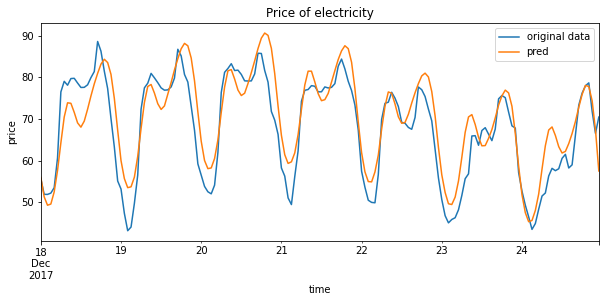

In [70]:
plt.rcParams['figure.figsize'] = (10, 4)
(test).price.plot(label="original data")
plt.ylabel('price')
pd.Series(predictions, index=test.index).plot(label="pred")
plt.title('Price of electricity')
plt.legend()
plt.show()

mean_absolute_error(test.price,predictions)

In [71]:
mean_absolute_error(test.price,predictions)

4.763774862894588

In [206]:
## PREDICTING TEST SET - submission 3 
test_split_date = '2017-12-25'
train_start_date = '2017-11-25'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=LinearRegression(), 
                  num_periods_lagged=0,
                  num_periods_diffed=1,
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

KeyboardInterrupt: 

<AxesSubplot:>

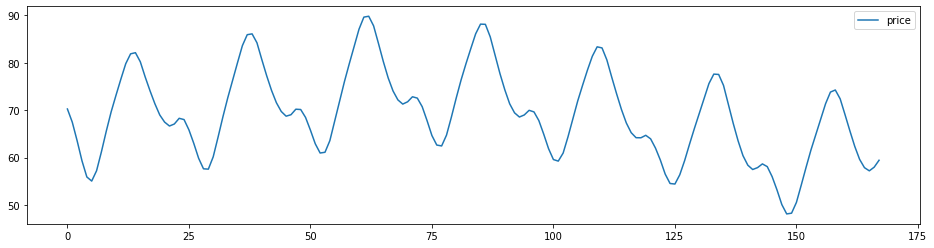

In [185]:
pd.DataFrame(data=predictions, columns=["price"]).plot()

In [97]:
submission = pd.DataFrame(data=predictions, columns=["price"])
submission.to_csv("linear_regression_submission3", index=False)

In [62]:
## PREDICTING TEST SET - submission 4 
test_split_date = '2017-12-25'
train_start_date = '2017-11-25'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(), 
                  num_periods_lagged=24,
                  num_periods_diffed=0,
                  lags=[],
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

<AxesSubplot:>

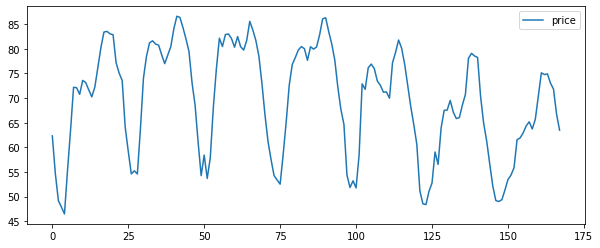

In [63]:
pd.DataFrame(data=predictions, columns=["price"]).plot()

In [64]:
submission = pd.DataFrame(data=predictions, columns=["price"])
submission.to_csv("gradient_boost_removed_exog_1month", index=False)

In [72]:
## PREDICTING TEST SET 
test_split_date = '2017-12-24'
train_start_date = '2017-11-25'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=LinearRegression(), 
                  num_periods_lagged=2,
                  num_periods_diffed=0,
                  lags=[],
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

<AxesSubplot:>

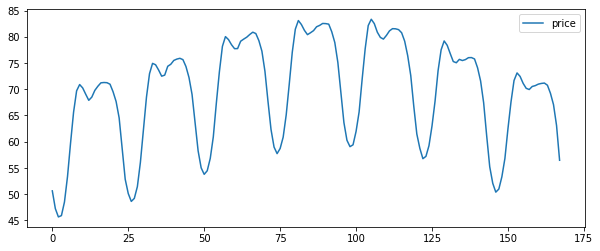

In [73]:
pd.DataFrame(data=predictions, columns=["price"]).plot()

In [74]:
submission = pd.DataFrame(data=predictions, columns=["price"])
submission.to_csv("linear_removed_exog_1month", index=False)

In [80]:
## PREDICTING TEST SET - all data - linear
test_split_date = '2017-12-24'
train_start_date = '2015-01-01'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test)+24, 
                  model=LinearRegression(), 
                  num_periods_lagged=2,
                  num_periods_diffed=0,
                  lags=[],
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/192 [00:00<?, ?it/s]

<AxesSubplot:>

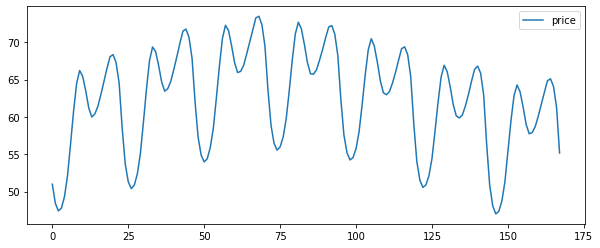

In [81]:
pd.DataFrame(data=predictions[24:], columns=["price"]).plot()

In [82]:
submission = pd.DataFrame(data=predictions[24:], columns=["price"])
submission.to_csv("linear_removed_exog_all_data", index=False)

In [86]:
## PREDICTING TEST SET - all data
test_split_date = '2017-12-25'
train_start_date = '2015-01-01'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(), 
                  num_periods_lagged=24,
                  num_periods_diffed=0,
                  lags=[],
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

<AxesSubplot:>

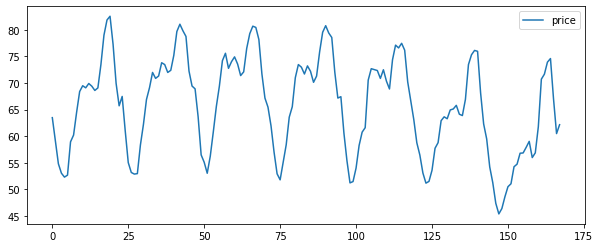

In [87]:
pd.DataFrame(data=predictions, columns=["price"]).plot()

In [88]:
submission = pd.DataFrame(data=predictions, columns=["price"])
submission.to_csv("gradient_removed_exog_all_data", index=False)

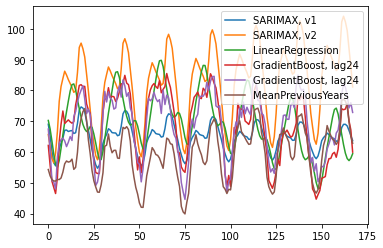

In [9]:
plt.plot(pd.read_csv("sarimax_no_exogenus_v1"), label="SARIMAX, v1") ##15
plt.plot(pd.read_csv("sarimax_no_exogenus_v2"), label="SARIMAX, v2") ##33
plt.plot(pd.read_csv("linear_regression_submission3"), label="LinearRegression") ##20 
plt.plot(pd.read_csv("gradient_boost_submission4"), label="GradientBoost, lag24") ##19
plt.plot(pd.read_csv("gradient_boost_with_exog_lag24"), label="GradientBoost, lag24") ##19

plt.plot(pd.read_csv("mean_previous_years"), label="MeanPreviousYears") ##11.85

plt.legend()

In [7]:
##ADDING EXOGENUS DATA
data = data_v2.copy()
data = build_exog_features(data, 168)

In [8]:
data = data.dropna()

In [9]:
from sklearn.model_selection import ParameterGrid
param_grid = {'model': [LinearRegression()], 
              'num_periods_lagged':[0, 1, 2, 24],
              'num_periods_diffed':[0],
              "lags": [[]],
              'hour': [True],
              'weekday':[True],
              'month':[True],
              'holidays': [True],
              'rolling' : [[],[np.mean,np.min,np.max,np.std]]
             }

grid = ParameterGrid(param_grid)

In [10]:
beginning_date = '2015-01-01'
val_split_date = '2017-12-11'
test_split_date = '2017-12-18'
train = data.loc[(beginning_date <= data.index) & (data.index < val_split_date)]
val = data.loc[(val_split_date <= data.index) & (data.index < test_split_date)]
test = data.loc[data.index >= test_split_date]

In [11]:
%%time 
# This is another cell that will take a long time to run. 

def wrap_model_selection(params): 
    predictions = predict_n_periods(series_=train, 
                      n_periods=len(val), 
                      model=params['model'], 
                      num_periods_lagged=params['num_periods_lagged'],
                      num_periods_diffed=params['num_periods_diffed'],
                      lags =params['lags'],
                      hour=params['hour'],
                      weekday=params['weekday'],
                      month=params['month'],
                      rolling=params["rolling"]
                    )
    return [params,mean_absolute_error(val.price,predictions)]

res = Parallel(n_jobs=-1)(delayed(wrap_model_selection)(params=params) 
                          for params in tqdm(grid))

<timed exec>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [100]:
df = pd.DataFrame(res, columns=['params','error'])
df.sort_values('error')


,params,error
15,"{'holidays': True, 'hour': True, 'lags': [], '...",7.824514
14,"{'holidays': True, 'hour': True, 'lags': [], '...",8.710984
4,"{'holidays': True, 'hour': True, 'lags': [], '...",9.970074
13,"{'holidays': True, 'hour': True, 'lags': [], '...",10.500346
11,"{'holidays': True, 'hour': True, 'lags': [], '...",10.517333
7,"{'holidays': True, 'hour': True, 'lags': [], '...",10.544146
9,"{'holidays': True, 'hour': True, 'lags': [], '...",10.703907
5,"{'holidays': True, 'hour': True, 'lags': [], '...",10.897779
6,"{'holidays': True, 'hour': True, 'lags': [], '...",11.019594
10,"{'holidays': True, 'hour': True, 'lags': [], '...",11.046197


In [104]:
df.sort_values('error').iloc[0][0]

{'holidays': True,
 'hour': True,
 'lags': [],
 'model': GradientBoostingRegressor(),
 'month': True,
 'num_periods_diffed': 0,
 'num_periods_lagged': 24,
 'rolling': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)>,
  <function numpy.amin(a, axis=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
  <function numpy.amax(a, axis=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
  <function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>, *, where=<no value>)>],
 'weekday': True}

In [105]:
#train = train.append(val)
test_split_date = '2017-12-18'
train_start_date = '2017-11-18'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]
test = data.loc[data.index >= test_split_date]

In [107]:
predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(),
                  num_periods_lagged=24,
                  num_periods_diffed=0,
                  lags=[],
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[np.mean,np.min,np.max,np.std],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

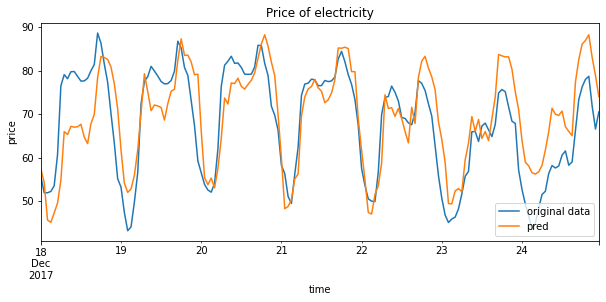

6.436582060121355

In [108]:
plt.rcParams['figure.figsize'] = (10, 4)
(test).price.plot(label="original data")
plt.ylabel('price')
pd.Series(predictions, index=test.index).plot(label="pred")
plt.title('Price of electricity')
plt.legend()
plt.show()

mean_absolute_error(test.price,predictions)

In [111]:
## PREDICTING TEST SET  - with exogenous data

test_split_date = '2017-12-25'
train_start_date = '2017-11-25'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(), 
                  num_periods_lagged=24,
                  num_periods_diffed=0,
                  lags=[],
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[np.mean,np.min,np.max,np.std],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

<AxesSubplot:>

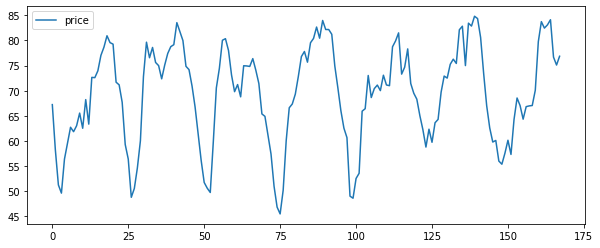

In [112]:
pd.DataFrame(data=predictions, columns=["price"]).plot()

In [113]:
submission = pd.DataFrame(data=predictions, columns=["price"])
submission.to_csv("gradient_boost_with_exog_1month", index=False)

In [180]:
## PREDICTING TEST SET  - with exogenous data

test_split_date = '2017-12-25'
train_start_date = '2015-01-01'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(), 
                  num_periods_lagged=24,
                  num_periods_diffed=0,
                  lags=[],
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[np.mean,np.min,np.max,np.std],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
#train = train.append(val)
test_split_date = '2017-12-18'
train_start_date = '2015-01-01'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]
test = data.loc[data.index >= test_split_date]

In [14]:
predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=LinearRegression(),
                  num_periods_lagged=2,
                  num_periods_diffed=0,
                  lags=[],
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

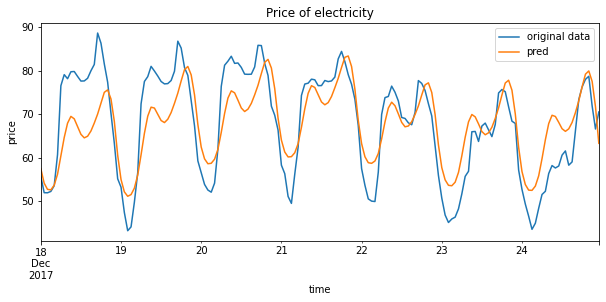

6.056624438400466

In [15]:
plt.rcParams['figure.figsize'] = (10, 4)
(test).price.plot(label="original data")
plt.ylabel('price')
pd.Series(predictions, index=test.index).plot(label="pred")
plt.title('Price of electricity')
plt.legend()
plt.show()

mean_absolute_error(test.price,predictions)

In [126]:
## PREDICTING TEST SET  - with exogenous data

test_split_date = '2017-12-24'
train_start_date = '2017-11-25'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test)+24, 
                  model=LinearRegression(),
                  num_periods_lagged=2,
                  num_periods_diffed=0,
                  lags=[],
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/192 [00:00<?, ?it/s]

<AxesSubplot:>

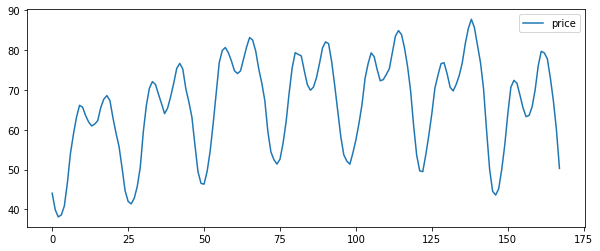

In [128]:
pd.DataFrame(data=predictions[24:], columns=["price"]).plot()

In [130]:
submission = pd.DataFrame(data=predictions[24:], columns=["price"])
submission.to_csv("linear_with_exog_1month", index=False)

In [132]:
## PREDICTING TEST SET  - with exogenous data - all data

test_split_date = '2017-12-24'
train_start_date = '2015-01-01'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test)+24, 
                  model=LinearRegression(),
                  num_periods_lagged=2,
                  num_periods_diffed=0,
                  lags=[],
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/192 [00:00<?, ?it/s]

<AxesSubplot:>

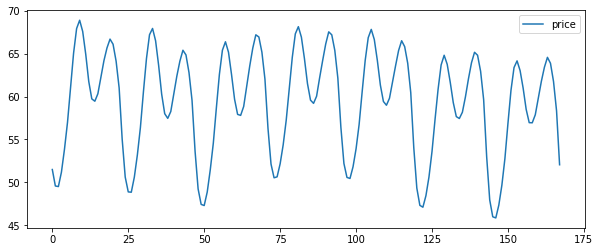

In [133]:
pd.DataFrame(data=predictions[24:], columns=["price"]).plot()

In [134]:
submission = pd.DataFrame(data=predictions[24:], columns=["price"])
submission.to_csv("linear_with_exog_all_data", index=False)

In [136]:
data.head()

,price,exog,exog_lead1,exog_lead2,exog_lead3,exog_lead4,exog_lead5,exog_lead6,exog_lead7,exog_lead8,...,exog_lead159,exog_lead160,exog_lead161,exog_lead162,exog_lead163,exog_lead164,exog_lead165,exog_lead166,exog_lead167,exog_lead168
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,64.92,5856.0,5454.0,5151.0,4861.0,4617.0,4276.0,3994.0,3602.0,3212.0,...,8004.0,7962.0,7779.0,7115.0,6110.0,5883.0,6276.0,6324.0,5755.0,5596.0
2015-01-01 01:00:00,64.48,5454.0,5151.0,4861.0,4617.0,4276.0,3994.0,3602.0,3212.0,2617.0,...,7962.0,7779.0,7115.0,6110.0,5883.0,6276.0,6324.0,5755.0,5596.0,5218.0
2015-01-01 02:00:00,59.32,5151.0,4861.0,4617.0,4276.0,3994.0,3602.0,3212.0,2617.0,2450.0,...,7779.0,7115.0,6110.0,5883.0,6276.0,6324.0,5755.0,5596.0,5218.0,4923.0
2015-01-01 03:00:00,56.04,4861.0,4617.0,4276.0,3994.0,3602.0,3212.0,2617.0,2450.0,2819.0,...,7115.0,6110.0,5883.0,6276.0,6324.0,5755.0,5596.0,5218.0,4923.0,4706.0
2015-01-01 04:00:00,53.63,4617.0,4276.0,3994.0,3602.0,3212.0,2617.0,2450.0,2819.0,2830.0,...,6110.0,5883.0,6276.0,6324.0,5755.0,5596.0,5218.0,4923.0,4706.0,4779.0


In [168]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [169]:
#Scale data

# define standard scaler
scaler = StandardScaler()
scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(data.drop(["price"], axis=1).values)


In [170]:
scaled_data = pd.DataFrame(scaled, index=data.index, columns=data.columns[1:])

In [8]:
predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(),
                
                  num_periods_lagged=0,
                                lags = [24],
                  num_periods_diffed=0,
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

6.219538971003211

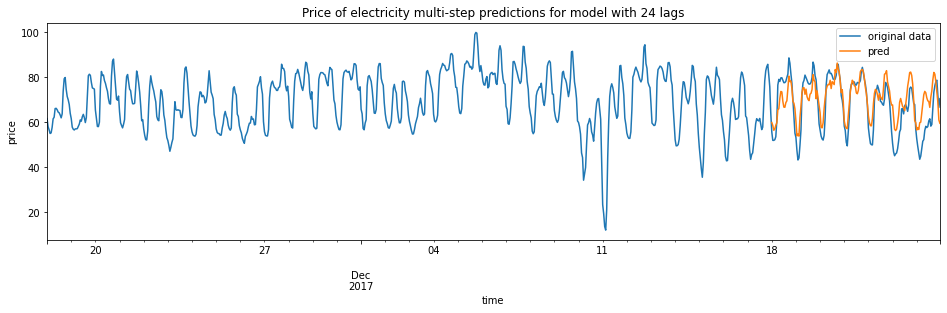

In [11]:
plt.rcParams['figure.figsize'] = (16, 4)
train.append(test).price.plot(label="original data")
plt.ylabel('price')
pd.Series(predictions, index=test.index).plot(label="pred")
plt.title('Price of electricity multi-step predictions for model with 24 lags')
plt.legend();
mean_absolute_error(test.price,predictions)

In [9]:

#train = train.append(val)
test_split_date = '2017-12-18'
train_start_date = '2016-01-01'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]
test = data.loc[data.index >= test_split_date]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(),
                
                  num_periods_lagged=0,
                                lags = [1, 2, 12, 24],
                  num_periods_diffed=0,
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

6.0116873731469544

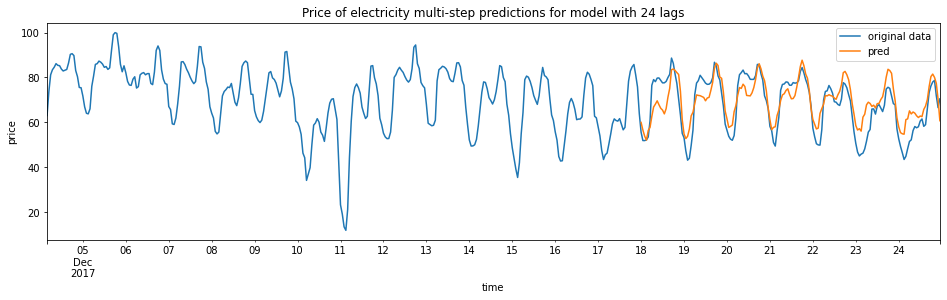

In [11]:
plt.rcParams['figure.figsize'] = (16, 4)
train.append(test).price[-500:].plot(label="original data")
plt.ylabel('price')
pd.Series(predictions, index=test.index).plot(label="pred")
plt.title('Price of electricity multi-step predictions for model with 24 lags')
plt.legend();
mean_absolute_error(test.price,predictions)

In [13]:
## PREDICTING TEST SET  - with exogenous data
test_split_date = '2017-12-25'
train_start_date = '2015-01-01'
train = data.loc[(train_start_date <= data.index) & (data.index < test_split_date)]

predictions = predict_n_periods(series_=train, 
                  n_periods=len(test), 
                  model=GradientBoostingRegressor(),
                
                  num_periods_lagged=0,
                                lags = [1, 2, 12, 24],
                  num_periods_diffed=0,
                  hour=True,
                  weekday=True,
                  month=True,
                  rolling=[],
                  holidays=True,
                  target="price"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

<AxesSubplot:>

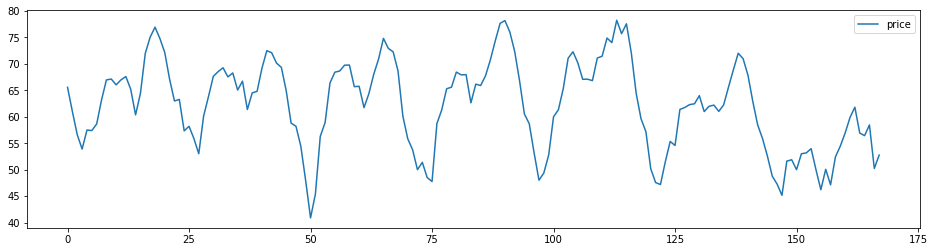

In [14]:
pd.DataFrame(data=predictions, columns=["price"]).plot()

In [15]:
submission = pd.DataFrame(data=predictions, columns=["price"])
submission.to_csv("gradient_boost_with_exog_all_data", index=False)

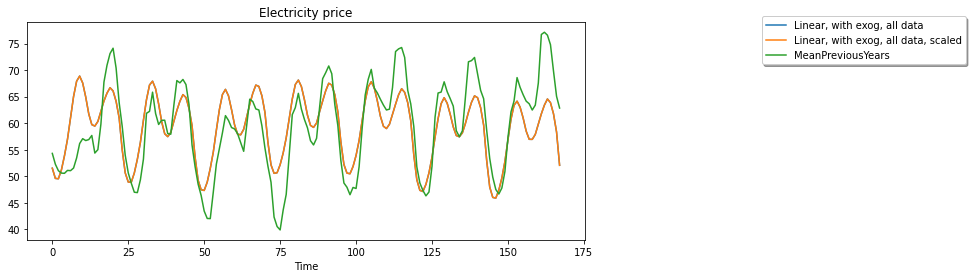

In [178]:
#plt.plot(pd.read_csv("sarimax_forecast_all_submission"), label="SARIMAX, v2") #18

#plt.plot(pd.read_csv("sarimax_forecast_exog_all_submission"), label="SARIMAX, v2, exog") #not submitted

#plt.plot(pd.read_csv("sarimax_forecast_all_v1_submission"), label="SARIMAX, v1") ##15

#plt.plot(pd.read_csv("sarimax_forecast_exog_all_v1_submission"), label="SARIMAX, v1, exog") #not submiitted
#plt.plot(pd.read_csv("gradient_boost_with_exog_all_data"), label="GradientBoost, exog, v2") #13
#plt.plot(pd.read_csv("gradient_boost_removed_exog_1month"), label="GradientBoost, removed exog, 1month") #21
#plt.plot(pd.read_csv("linear_removed_exog_1month"), label="LinearRegression, removed exog, 1month") #21
#plt.plot(pd.read_csv("linear_removed_exog_all_data"), label="LinearRegression, removed exog, all data") #14
#plt.plot(pd.read_csv("gradient_removed_exog_all_data"), label="GradientBoost, removed exog, all data") #17
#plt.plot(pd.read_csv("gradient_boost_with_exog_1month"), label="GradientBoost, with exog, 1month") #20
#plt.plot(pd.read_csv("linear_with_exog_1month"), label="Linear, with exog, 1month") #18
plt.plot(pd.read_csv("linear_with_exog_all_data"), label="Linear, with exog, all data") #11.24
plt.plot(pd.read_csv("linear_with_exog_all_data_scaled"), label="Linear, with exog, all data, scaled") #11.24



#plt.plot(pd.read_csv("sarimax_no_exogenus_v2"), label="SARIMAX, v2") ##33
#plt.plot(pd.read_csv("linear_regression_submission3"), label="LinearRegression") ##20 
#plt.plot(pd.read_csv("gradient_boost_submission4"), label="GradientBoost, lag24") ##19
#plt.plot(pd.read_csv("gradient_boost_with_exog_lag24"), label="GradientBoost, lag24, with exog") ##19
plt.plot(pd.read_csv("mean_previous_years"), label="MeanPreviousYears") ##11.85

plt.xlabel('Time')
plt.title('Electricity price')
plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1.05), fancybox=True, shadow=True)
plt.show()